#How to make a tailored TED talk? 

TED asks viewers to rate talks using 14 rating words shown below instead of using like or dislike. It would be interesting to discover the keys to make a tailored talk, "tailored" means tailored to a certain emotional/intellectual need from the viewer, either touching, convincing, funny etc. 

<img src="tedrating.png" height = 400 width = 400 align = "left">

### Import all libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import requests
from pattern import web
import operator
import random as rd

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

In [5]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import label_binarize
from unidecode import unidecode
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.base import BaseEstimator,TransformerMixin

In [6]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

##1. Feature and target variable preprocessing

###1.1 Themes 

The first feature is the theme of the talk, labeled by TED. There are totally 47 themes. Each talk can be associated with multiple themes. The theme data is stored in train2.json, which is the preprocessed json file that contains information of all talks in the training set. This was obtained using TED API. A vector of length 47 is generated for each talk to store this information. 

In [8]:
talks_small = pd.read_json('train2.json')
talks_small.reset_index(drop = True, inplace = True)

In [9]:
# convert the theme dictionary to list of themes
def themes_fun(row):
    # convert the original themes (dict) to list
    themes = []
    for theme in row['themes']:
        themes.append(theme['theme']['name'])
    return themes

In [10]:
themes = []
for i in xrange(talks_small.shape[0]):
    themes.append(themes_fun(talks_small.ix[i,:]))

All themes are listed in vocab_theme, they are obtained through TED API

In [12]:
vocab_theme = [u'Live Music',u'Celebrating TEDWomen',u'Whipsmart Comedy',u'Listening to Teachers',u'Spectacular Performance',
 u'Ocean Wonders',u'Bold Predictions, Stern Warnings',u'What Makes Us Happy?',u'Media With Meaning',u'Technology, History and Destiny',
 u'How the Mind Works',u'Talks from TED Fellows',u'Medicine Without Borders',u'Hidden Gems',u'War and Peace',
 u'The Rise of Collaboration',u'TED Prize Winners',u"Evolution's Genius",u'Unconventional Explanations',u"What's Next in Tech",
 u'Presentation Innovation',u'Words About Words',u'Numbers at Play',u'Women Reshaping the World',u'Art Unusual',
 u'Not Business as Usual',u'To Boldly Go ...',u'Architectural Inspiration',u'Africa: The Next Chapter',u'TED in 3 Minutes',
 u'Tales of Invention',u'Inspired by Nature',u'Is There a God?',u'Design That Matters',u'Food Matters',u'How We Learn',u'Master Storytellers',
 u'Animals That Amaze',u'The Power of Cities',u'A Greener Future?',u'The Creative Spark',u'Peering into Space',u'Best of the Web',
 u'Rethinking Poverty',u'The Charter for Compassion',u'Might You Live a Great Deal Longer?',u'Mission Blue Voyage']

In [13]:
vocab_theme[1]

u'Celebrating TEDWomen'

In [14]:
talks_small['themes'] = themes

In [15]:
talks_small['themes'] = talks_small['themes'].apply(lambda x: ' '.join(x))

The maximum length of all themes is 35 grams, therefore use ngram_range = (2,40) to convert the theme feature into a vector

In [17]:
# shortest themes are of 2 words, longest 7words
Cvtheme = CountVectorizer(vocabulary=vocab_theme,binary = True, analyzer='char',ngram_range=(2,40),lowercase = False)

### 1.2 Convert onespeaker feature into integer 

In [18]:
talks_small['onespeaker'] = (talks_small['onespeaker']==True).astype(int)

### 1.3 Process the label (resonse variable)

In [19]:
labels = pd.read_csv('response5.csv',header =None )
labels.columns = ['id','label']

In [20]:
counts = labels.groupby('label')['label'].count()

In [21]:
fractions = counts/counts.sum()

In [22]:
fractions.index = ['persuasive informative','beautiful courageous inspiring','jaw-dropping ingenious fascinating',
                  'ok obnoxious confusing unconvincing long-winded', 'funny']

In [23]:
fractions

persuasive informative                             0.308795
beautiful courageous inspiring                     0.272313
jaw-dropping ingenious fascinating                 0.229967
ok obnoxious confusing unconvincing long-winded    0.116612
funny                                              0.072313
Name: label, dtype: float64

#### Make a plot of label distribution in the training set

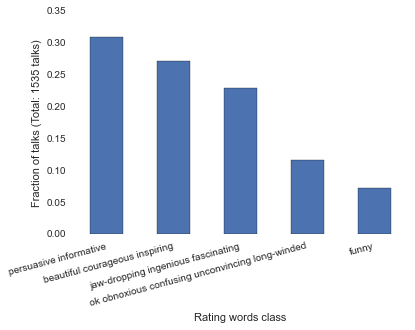

In [24]:
fractions.plot(kind = 'bar')
plt.xticks(rotation = 15, ha = 'right')
plt.ylabel('Fraction of talks (Total: 1535 talks)')
plt.xlabel('Rating words class')

##2. Construct final training set Xdf and y, which is the label 

###2.1 Features from talks_small are id, theme and speaker_gender

In [25]:
Xdf = talks_small[['id','themes','speaker_gender']]

In [26]:
Xdf = Xdf.sort(columns = 'id')

###2.2 Features from captions, processed in Ted_2 

In [27]:
caps = pd.read_json('captions_f.json')[['id','length','num_para','word_per_sec','laughter_per_word','laugh_as_para',
                                     'applause_total','div_per_word','ithinks','storywords','noun_token','verb_token']]

In [28]:
caps = caps.sort(columns = 'id')

In [29]:
caps.reset_index(inplace = True, drop = True)

### 2.3 Features from other text source (title + keywords + description), generated in Ted_5

In [30]:
Xother = pd.read_json('talks_other_text.json')

In [31]:
Xother.sort(columns = 'id',inplace = True)

In [32]:
Xother.reset_index(inplace = True, drop = True)

###2.4 Merge all three sources into Xdf 

In [33]:
Xdf = pd.merge(Xdf,caps,on = 'id')

In [34]:
Xdf = pd.merge(Xdf,Xother, on = 'id')

In [35]:
Xdf.sort(columns = 'id',inplace = True)

###2.5 Generate y from labels 

In [36]:
labels.sort(columns = 'id',inplace = True)

In [37]:
labels.reset_index(drop = True, inplace = True)

In [38]:
y = labels[['label']].values.flatten()

## 3 Train the model

### 3.1 a single test-train split 

In [39]:
sss = StratifiedShuffleSplit(y, n_iter = 1, test_size=0.2, random_state=1)

In [40]:
for train_index,test_index in sss:
    Xdftrain,Xdftest = Xdf.ix[train_index,:],Xdf.ix[test_index,:]
    ytrain,ytest = y[train_index],y[test_index]

####3.1.1 Convert the text(title +kw + description) into a matrix using CountVectorizer

In [41]:
Xtrain_text = Xdftrain['text'].as_matrix()

In [42]:
Xtest_text = Xdftest['text'].as_matrix()

##### the following list is derived in Ted_5_NLP_other 

In [43]:
final_text_words = ['global issues', 'science', 'culture', 'new','humor','entertainment']

In [44]:
vect_other = CountVectorizer(vocabulary = final_text_words, stop_words = 'english', ngram_range = (1,2))

In [45]:
Xtrain_text_other = vect_other.fit_transform(Xtrain_text)

In [46]:
Xtest_text_other = vect_other.transform(Xtest_text)

#### 3.1.2 Convert themes into a matrix using Cvtheme (a CountVectorizer) defined previously

In [47]:
Xtrain_th = Cvtheme.fit_transform(Xdftrain.ix[:,'themes'].as_matrix())

In [48]:
Xtest_th = Cvtheme.transform(Xdftest.ix[:,'themes'].as_matrix())

#### 3.1.3 Convert verb and noun tokens in the caption to a matrix using TfidfVectorizer

##### the vocabulary lists are derived in Ted_2_NLP_caption 

Both noun and verb vocabulary are selected by the following procedure:
    1. tokens that have log probability larger than -3 are filtered out
    2. tokens must appear in more than 60% of talks in the selected class
    3. vocabulary of each class are combined to form the ultimate noun or verb vocabulary

In [49]:
vocab_verb_final = [u'like',u'show',u'feel',u'should',u'leave',u'live',u'understand',u'talk',u'ask',u'become',u'change']

In [50]:
vocab_noun_final = [u'life',u'percent',u'question',u'story',u'idea',u'part',u'place',u'fact',u'example',u'problem',u'bit',u'kind',u'today']

In [51]:
tf_noun = TfidfVectorizer(vocabulary = vocab_noun_final,use_idf = False, sublinear_tf = True)

In [52]:
tf_verb = TfidfVectorizer(vocabulary = vocab_verb_final,use_idf = False, sublinear_tf = True)

In [53]:
Xtrain_noun = tf_noun.fit_transform(Xdftrain.ix[:,'noun_token'].as_matrix())

In [54]:
Xtest_noun = tf_noun.transform(Xdftest.ix[:,'noun_token'].as_matrix())

In [55]:
Xtrain_verb = tf_verb.fit_transform(Xdftrain.ix[:,'verb_token'].as_matrix())

In [56]:
Xtest_verb = tf_verb.transform(Xdftest.ix[:,'verb_token'].as_matrix())

#### 3.1.4 Combine all features into Xtrain, Xtest

In [57]:
Xtrain = np.concatenate([Xtrain_th.toarray(),Xtrain_noun.toarray(),Xtrain_verb.toarray(),
                          Xtrain_text_other.toarray(), scale(Xdftrain.ix[:,2:12].as_matrix())],
                         axis = 1)

In [58]:
Xtest = np.concatenate([Xtest_th.toarray(),Xtest_noun.toarray(),Xtest_verb.toarray(),
                         Xtest_text_other.toarray(), scale(Xdftest.ix[:,2:12].as_matrix())],axis = 1)

#### 3.1.5 Test logistic regression and random forest 

#### Logistic Regresion

In [59]:
clf = LogisticRegression(C = 10, penalty = 'l2',class_weight = 'auto')

In [60]:
clf.fit(Xtrain,ytrain)

LogisticRegression(C=10, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [61]:
ytest_pred = clf.predict(Xtest)

In [62]:
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.64      0.66      0.65        95
          1       0.67      0.64      0.65        84
          2       0.56      0.55      0.55        71
          3       0.35      0.25      0.29        36
          4       0.52      0.77      0.62        22

avg / total       0.59      0.59      0.59       308



####Confusion matrix of the prediction 

In [63]:
pd.crosstab(ytest_pred,ytest,rownames=['Predicted'],colnames = ['True label'],margins = True)

True label,0,1,2,3,4,All
Predicted,,,,,,
0,63,13,12,9,1,98
1,8,54,8,9,2,81
2,15,8,39,7,1,70
3,6,2,8,9,1,26
4,3,7,4,2,17,33
All,95,84,71,36,22,308


#### make a list of feature names

In [64]:
other_vocab = sorted(vect_other.vocabulary_.items(), key = operator.itemgetter(1))

In [65]:
other_vocab = [x[0] for x in other_vocab]

In [66]:
noun_vocab = sorted(tf_noun.vocabulary_.items(), key = operator.itemgetter(1))

In [67]:
noun_vocab = [x[0] for x in noun_vocab]

In [68]:
verb_vocab = sorted(tf_verb.vocabulary_.items(), key = operator.itemgetter(1))

In [69]:
verb_vocab = [x[0] for x in verb_vocab]

In [70]:
feature_names = list(vocab_theme) + noun_vocab + verb_vocab + other_vocab + list(Xdftrain.columns[2:12])

In [71]:
feature_names[77:] = ['speaker_gender','talk_length','num_paragraph','words_per_sec','laughter_per_word',
                     'laughter_as_paragraph','applause_total','interjections_per_word','Ithink','story_words']

###3.2 Use cross-validation on the whole training set to tune regularization parameter

In [72]:
Xth = Xdf['themes'].as_matrix()

In [73]:
Xth = Cvtheme.fit_transform(Xth)

In [74]:
Xtext_other = vect_other.transform(Xdf['text'].as_matrix())

In [75]:
X_noun = tf_noun.fit_transform(Xdf['noun_token'].as_matrix())

In [76]:
X_verb = tf_verb.fit_transform(Xdf['verb_token'].as_matrix())

In [77]:
X = np.concatenate([Xth.toarray(),X_noun.toarray(), X_verb.toarray(),
                    Xtext_other.toarray(),scale(Xdf.ix[:,2:12].as_matrix())],axis = 1)

#### Grid search to optimize "C" for Logistic Regression

In [78]:
param_logit = {'C':np.logspace(-2,2,20)}

In [79]:
clf2 = LogisticRegression(class_weight = 'auto',solver = 'lbfgs')

In [80]:
gs_logit = GridSearchCV(clf2, param_grid = param_logit, cv = StratifiedKFold(y,n_folds = 5), scoring = 'f1_micro')

In [81]:
gs_logit.fit(X,y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[4 1 ..., 1 2], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.62378e-02,   2.63665e-02,   4.28133e-02,
         6.95193e-02,   1.12884e-01,   1.83298e-01,   2.97635e-01,
         4.83293e-01,   7.84760e-01,   1.27427e+00,   2.06914e+00,
         3.35982e+00,   5.45559e+00,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='f1_micro', verbose=0)

In [82]:
print 'Best parameters set:'
best_parameters = gs_logit.best_estimator_.get_params()
for param_name in sorted(param_logit.keys()):
    print '\t%s: %r' % (param_name,best_parameters[param_name])

Best parameters set:
	C: 0.29763514416313175


#### The optimized logistic regression model 

In [83]:
logit = gs_logit.best_estimator_

#### Random Forest to estimate the overall feature importance

In [84]:
rf = RandomForestClassifier(n_estimators= 300, criterion='gini',class_weight = 'auto',oob_score=True)

In [85]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [86]:
rf.oob_score_

0.54788273615635175

In [87]:
feature_importance = pd.Series(rf.feature_importances_,index = feature_names)

In [88]:
feature_importance.sort()

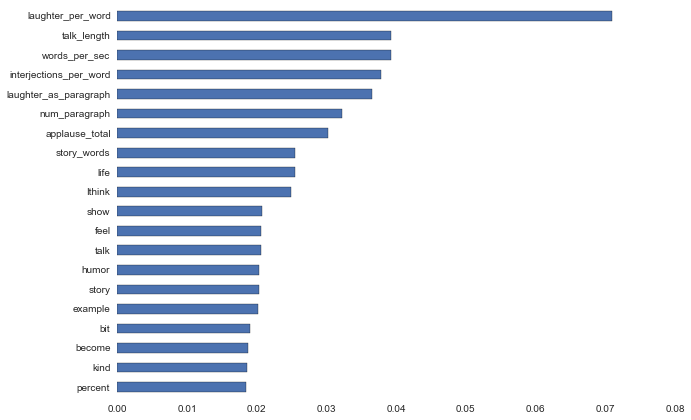

In [89]:
figure = plt.figure(figsize = (10,7))
feature_importance.ix[-20:].plot(kind = 'barh')

## 4. Prediction on the test set (350 talks)

In [91]:
finaltest = pd.read_json('test2.json')
finaltest.sort(columns = 'id',inplace = True)
finaltest.reset_index(inplace = True, drop = True)

###4.2 Process themes 

In [92]:
final_themes = []
for i in xrange(finaltest.shape[0]):
    final_themes.append(themes_fun(finaltest.ix[i,:]))

In [93]:
finaltest['themes']=final_themes

In [94]:
finaltest['themes']=finaltest['themes'].apply(lambda x: ' '.join(x))

###4.3 Process labels and generate y 

In [96]:
testlabels = pd.read_csv('test_response.csv',header =None )
testlabels.columns = ['id','label']

In [104]:
testlabels.sort(columns = 'id',inplace = True)
testlabels.reset_index(drop = True, inplace = True)
yfinal = testlabels[['label']].values.flatten()

###4.4 Combine all features into Xdftest 

####4.4.1 From talk information

In [97]:
Xdftest = finaltest[['id','themes','speaker_gender']]

####4.4.2 From caption 

In [99]:
caps_test = pd.read_json('captions_test_f.json')[['id','length','num_para','word_per_sec','laughter_per_word','laugh_as_para',
                                     'applause_total','div_per_word','ithinks','storywords','noun_token','verb_token']]

In [100]:
caps_test.sort('id',inplace = True)
caps_test.reset_index(inplace = True, drop = True)

####4.4.3 From description, title and keywords 

In [102]:
Xtestother = pd.read_json('validset_other_text.json')
Xtestother.sort(columns = 'id',inplace = True)
Xtestother.reset_index(inplace = True, drop = True)

####4.4.4 Merge all features 

In [103]:
Xdftest = pd.merge(Xdftest, Xtestother, on = 'id')
Xdftest = pd.merge(Xdftest, caps_test, on = 'id')
Xdftest.sort(columns = 'id',inplace = True)

###4.5 Make feature matrix

In [105]:
Xth_test = Xdftest['themes'].as_matrix()
Xth_test = Cvtheme.transform(Xth_test)

In [106]:
Xtext_other_test = vect_other.transform(Xdftest['text'].as_matrix())

In [107]:
X_noun_test = tf_noun.transform(Xdftest['noun_token'].as_matrix())
X_verb_test = tf_verb.fit_transform(Xdftest['verb_token'].as_matrix())

In [108]:
newcol = [u'id',u'themes',u'speaker_gender',u'length',u'num_para',u'word_per_sec',u'laughter_per_word',
 u'laugh_as_para',u'applause_total',u'div_per_word',u'ithinks',u'storywords',u'text',u'noun_token',u'verb_token']

In [109]:
Xdftest = Xdftest[newcol]

In [110]:
Xfinal = np.concatenate([Xth_test.toarray(),X_noun_test.toarray(), X_verb_test.toarray(),
                    Xtext_other_test.toarray(),scale(Xdftest.ix[:,2:12].as_matrix())],axis = 1)

###4.6 Prediction 

In [112]:
yfinal_pred_logit = logit.predict(Xfinal)

In [113]:
print classification_report(yfinal, yfinal_pred_logit)

             precision    recall  f1-score   support

          0       0.62      0.62      0.62       111
          1       0.56      0.47      0.51        89
          2       0.62      0.65      0.64        81
          3       0.33      0.36      0.34        36
          4       0.55      0.64      0.59        33

avg / total       0.57      0.57      0.57       350



####compare against the base rate: the proportion of each label in the training set 

In [115]:
final_precision = pd.Series([0.62, 0.56, 0.62, 0.33, 0.55])

In [114]:
final_recall = pd.Series([0.62, 0.47, 0.65, 0.36, 0.64])

In [116]:
final_f1 = pd.Series([0.62, 0.51, 0.64, 0.34, 0.59])

In [117]:
tempdf = pd.DataFrame(dict(fractions = fractions.values,final_f1 = final_f1, final_recall = final_recall,
                          final_precision = final_precision))

In [118]:
tempdf = tempdf[['fractions','final_f1','final_recall','final_precision']]
tempdf.index = fractions.index
tempdf.columns= ['Label fractions','Prediction F1 scores','Prediction recall','Prediction precision']

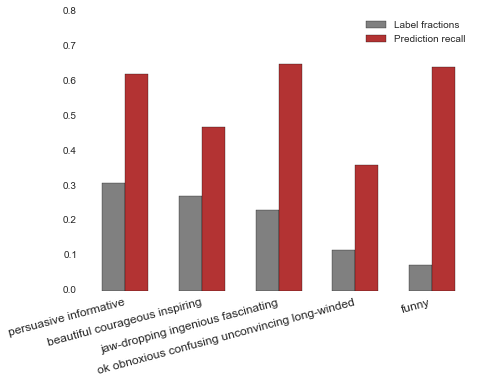

In [120]:
fig = plt.figure(figsize=(7,5))
ax3 = plt.gca()
tempdf[['Label fractions','Prediction recall']].plot(kind = 'bar',color = [(0.5,0.5,0.5),(0.7,0.2,0.2)]
                                                                           ,ax = ax3,width = 0.6,left = [0,0.2,0.4,0.6])
plt.xticks(rotation = 15, ha = 'right',fontsize = 'large')
plt.ylim([0,0.8])
plt.legend(loc = 'best')

##5 Key features to each class

###5.1 Generate a dataframe of feature importance (importance_df) and a dataframe of all final features (Xdf_allf)

In [121]:
importance_df = pd.DataFrame(logit.coef_,columns=feature_names)

#####All unscaled features and label are stored in Xdf_allf 

In [122]:
X_unscaled = np.concatenate([Xth.toarray(),X_noun.toarray(), X_verb.toarray(),
                    Xtext_other.toarray(),Xdf.ix[:,2:12].as_matrix()],axis = 1)

In [123]:
Xdf_allf = pd.DataFrame(X_unscaled,columns=feature_names)

In [124]:
Xdf_allf = pd.merge(Xdf_allf, labels, right_index = True,left_index = True)

####Define a function to get the largest (absolute) coefficients from the logistic regression model and corresponding features for each class 

The features in feature_names are divided into five categories and they are ordered as follows:  
    **theme**: 0:46 are themes  
    **noun**: 47:59 are the important nouns from the caption  
    **verb**: 60:70 are the important verbs from the caption  
    **keywords**: 71:76 are the the key words selected from other text source (description, tag and title)  
    **delivery and audience feedback**: 77:86 are the ad hoc features: speaker_gender, talk_length, num_paragraph, words_per_sec, laughter_per_word, laughter_as_paragraph, applause_total, interjection_per_word, Ithink, story_words

In [126]:
# make a dictionary to select feature types based on above
feature_type = dict(theme = range(0,47), noun = range(47,60), verb = range(60,71),
                   keywords = range(71,77),delivery = range(77,86))

In [127]:
def importantf(row_in_df, num=3,ftype = 'theme'):
    # row_in_df is one row in importance_df, num is the number of best and worst features in this particular type
    # specified by ftype
    row_slice = feature_type[ftype]
    row = row_in_df[row_slice]
    key_features = []
    coefs = []
    for ind in xrange(num):
        # print 'top {} good feature is {} with coef: {}'.format(ind, row.idxmax(),row.max())
        key_features.append(row.idxmax())
        coefs.append(row.max())
        key_features.append(row.idxmin())
        coefs.append(row.min())
        row = row[row.index != row.idxmax()]
        row = row[row.index != row.idxmin()]
        
    zipped = zip(key_features,coefs)
    zipped.sort(key = lambda x: x[1],reverse = True)
    return zipped

In [128]:
# define a function to plot bubble chart
def bubbleplot(zipped,size_factor,ax):
    keyfeatures,coefs = zip(*zipped)
    num = len(keyfeatures)
    # rd.seed(150)
    xcoor = rd.sample(range(10),num)#+np.random.normal(0,1,6)
    # rd.seed(123)
    ycoor = rd.sample(range(10),num)#+np.random.normal(0,1,6)
    
    color = [(x>0).astype(int) for x in coefs]
    abs_coef = [abs(x) for x in coefs]
    size = [size_factor*x for x in abs_coef]
    for ind in xrange(num):
        ax.text(xcoor[ind],ycoor[ind],keyfeatures[ind],size = 11, horizontalalignment = 'center')
    plt.xlim(-3,12)
    plt.ylim(-3,14)
    
    ax.scatter(xcoor, ycoor, c = color, s=size, linewidths=2, edgecolor='w',cmap = 'cool',alpha = 0.75)
    ax.set_xticks([])
    ax.set_yticks([])

### 5.2 How to make a rationally convincing TED talk: rated by "informative" and "persuasive" 

In [129]:
row_0 = importance_df.ix[0,:]

In [130]:
keythemes = importantf(row_0)

In [131]:
keynouns = importantf(row_0,num = 3,ftype = 'noun')

In [132]:
keyverbs = importantf(row_0,num = 3,ftype = 'verb')

In [133]:
keydeli = importantf(row_0,num = 3,ftype = 'delivery')

In [134]:
keykw = importantf(row_0,num = 3,ftype = 'keywords')

##### make a bubble chart of the most likely and unlikely themes, nouns and verbs used in this class

bubble charts are used to show relative importance of features. Features are plotted in five subplots showing each category of features (Theme, Noun, Verb, etc.). 
    1. size of the bubble correlates with the absolute value of the coefficients.
    2. color of the bubble indicates the sign of the coefficiencts: cyan: negative, purple: positive

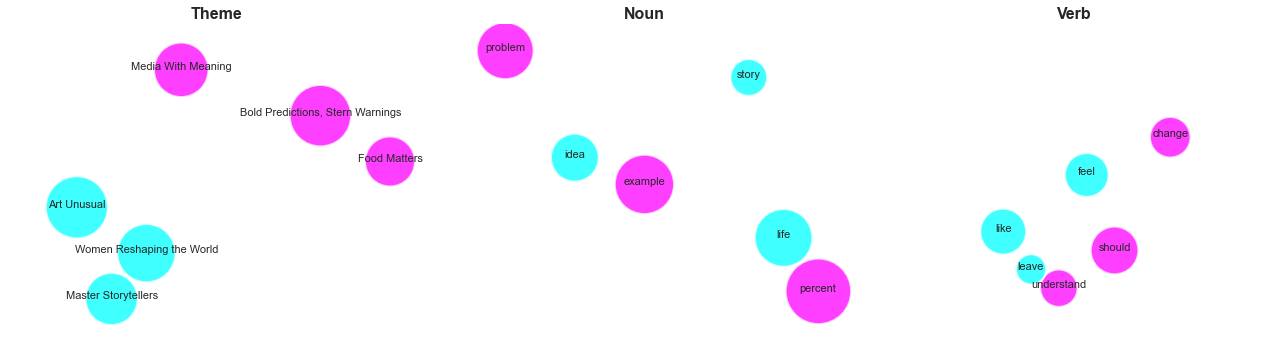

In [135]:
fig, axes=plt.subplots(figsize = (18,5),nrows=1, ncols=3)
titles = ['Theme','Noun','Verb']
keys = [keythemes,keynouns,keyverbs]
for ind in xrange(3):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,ax)
    ax.set_title(titles[ind],fontsize = 16, fontweight = 'bold')
fig.tight_layout()

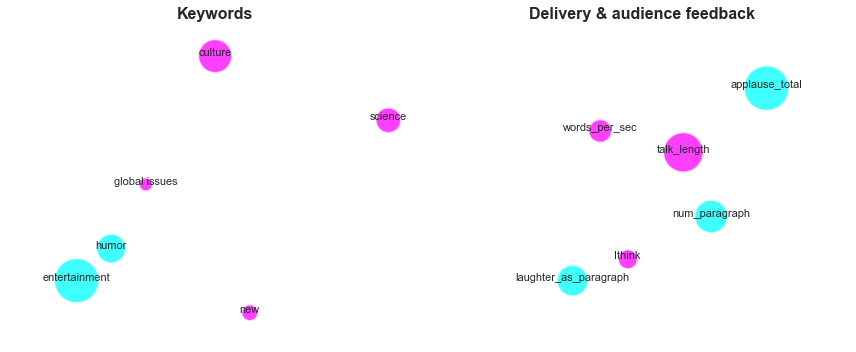

In [511]:
fig, axes=plt.subplots(figsize = (12,5),nrows=1, ncols=2)
titles = ['Keywords','Delivery & audience feedback']
keys = [keykw,keydeli]
for ind in xrange(2):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,ax)
    ax.set_title(titles[ind],fontsize = 16, fontweight = 'bold')
fig.tight_layout()

###5.3 How to make an emotionally touching TED talk: courageous, beautiful and inspiring

In [476]:
row_1 = importance_df.ix[1,:]

In [491]:
keythemes1,keynouns1,keyverbs1,keykws1,keydeli1 = importantf(row_1),importantf(row_1,ftype = 'noun'),importantf(row_1,ftype = 'verb'),importantf(row_1,ftype = 'keywords'),importantf(row_1,ftype = 'delivery')

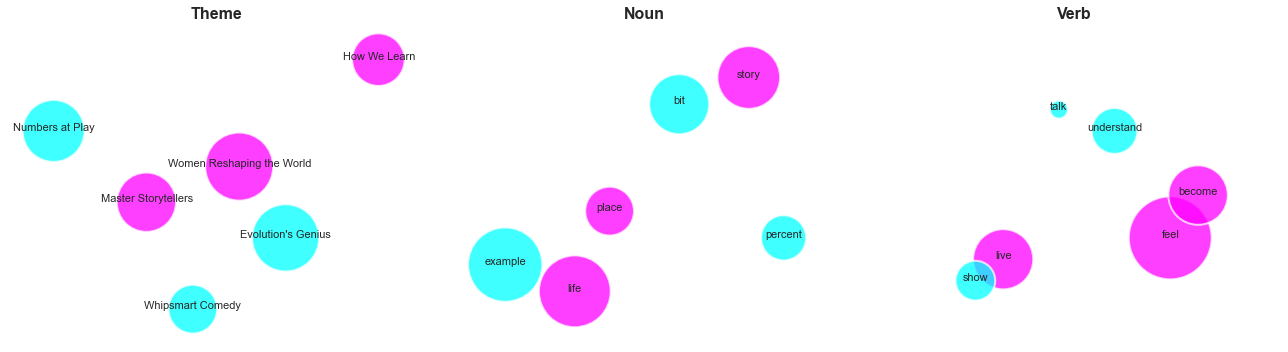

In [492]:
fig, axes=plt.subplots(figsize = (18,5),nrows=1, ncols=3)
titles = ['Theme','Noun','Verb']
keys = [keythemes1,keynouns1,keyverbs1]
for ind in xrange(3):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,axes[ind])
    ax.set_title(titles[ind],fontsize = 16, fontweight = 'bold')
fig.tight_layout()

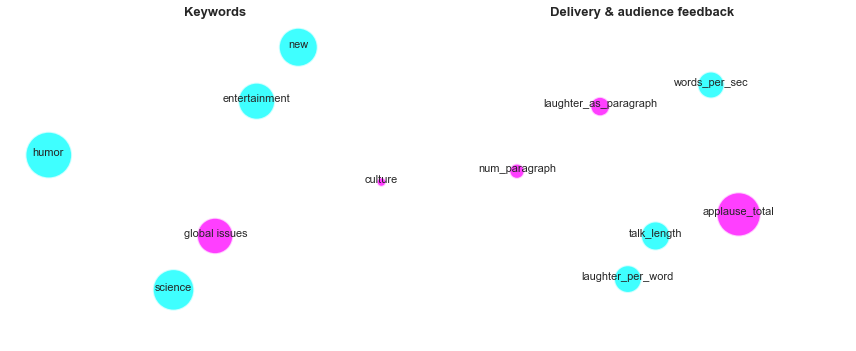

In [529]:
fig, axes=plt.subplots(figsize = (12,5),nrows=1, ncols=2)
titles = ['Keywords','Delivery & audience feedback']
keys = [keykw1,keydeli1]
for ind in xrange(2):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,ax)
    ax.set_title(titles[ind],fontsize = 13, fontweight = 'bold')
fig.tight_layout()

###5.4 Jaw-dropping TED talks 

In [516]:
row_2 = importance_df.ix[2,:]

In [517]:
keythemes2,keynouns2,keyverbs2,keykws2,keydeli2 = importantf(row_2),importantf(row_2,ftype = 'noun'),importantf(row_2,ftype = 'verb'),importantf(row_2,ftype = 'keywords'),importantf(row_2,ftype = 'delivery')

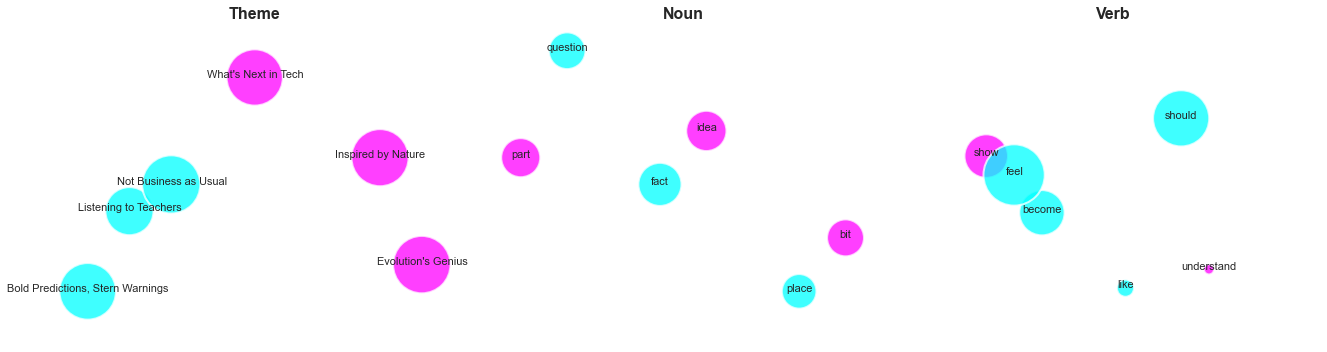

In [535]:
fig, axes=plt.subplots(figsize = (18,5),nrows=1, ncols=3)
titles = ['Theme','Noun','Verb']
keys = [keythemes2,keynouns2,keyverbs2]
for ind in xrange(3):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,axes[ind])
    ax.set_title(titles[ind],fontsize = 16, fontweight = 'bold')
fig.tight_layout()

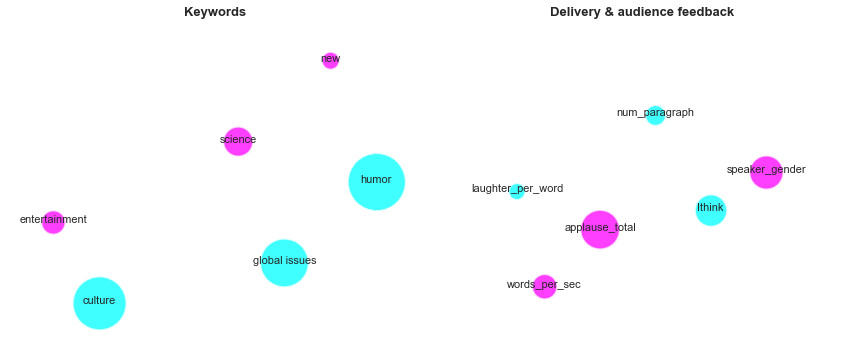

In [536]:
fig, axes=plt.subplots(figsize = (12,5),nrows=1, ncols=2)
titles = ['Keywords','Delivery & audience feedback']
keys = [keykws2,keydeli2]
for ind in xrange(2):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,ax)
    ax.set_title(titles[ind],fontsize = 13, fontweight = 'bold')
fig.tight_layout()

###5.5 Negatively rated class 

In [522]:
row_3 = importance_df.ix[3,:]

In [523]:
keythemes3,keynouns3,keyverbs3,keykws3,keydeli3 = importantf(row_3),importantf(row_3,ftype = 'noun'),importantf(row_3,ftype = 'verb'),importantf(row_3,ftype = 'keywords'),importantf(row_3,ftype = 'delivery')

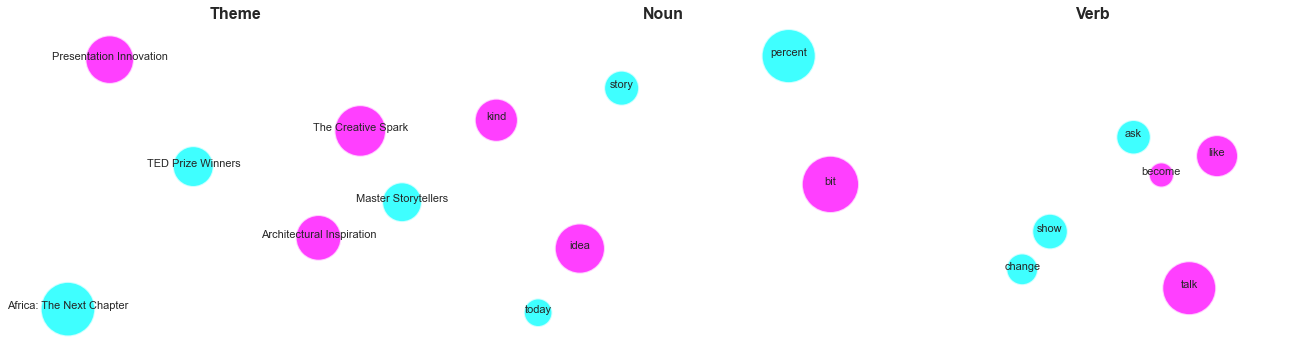

In [537]:
fig, axes=plt.subplots(figsize = (18,5),nrows=1, ncols=3)
titles = ['Theme','Noun','Verb']
keys = [keythemes3,keynouns3,keyverbs3]
for ind in xrange(3):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,axes[ind])
    ax.set_title(titles[ind],fontsize = 16, fontweight = 'bold')
fig.tight_layout()

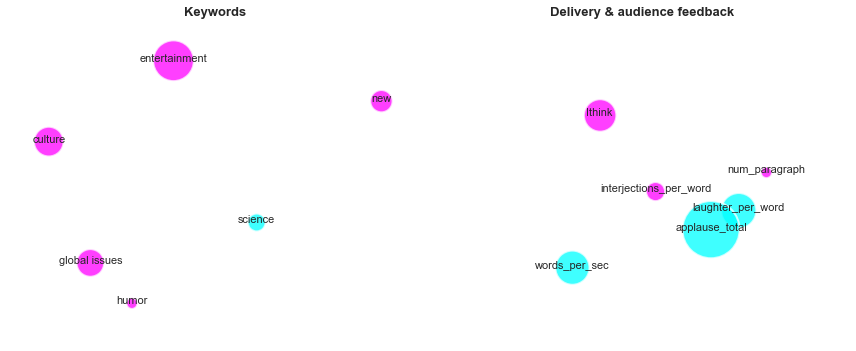

In [538]:
fig, axes=plt.subplots(figsize = (12,5),nrows=1, ncols=2)
titles = ['Keywords','Delivery & audience feedback']
keys = [keykws3,keydeli3]
for ind in xrange(2):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,ax)
    ax.set_title(titles[ind],fontsize = 13, fontweight = 'bold')
fig.tight_layout()

###5.6 Funny TED talks 

In [530]:
row_4 = importance_df.ix[4,:]

In [531]:
keythemes4,keynouns4,keyverbs4,keykws4,keydeli4 = importantf(row_4),importantf(row_4,ftype = 'noun'),importantf(row_4,ftype = 'verb'),importantf(row_4,ftype = 'keywords'),importantf(row_4,ftype = 'delivery')

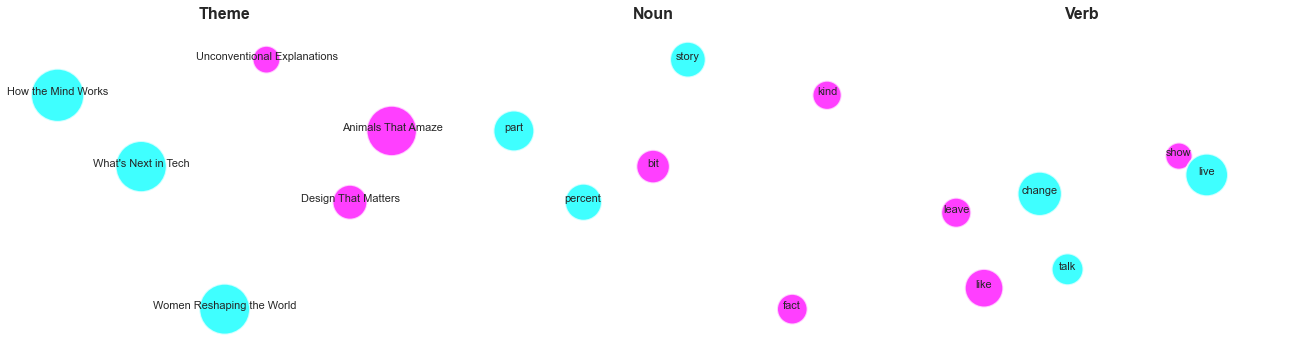

In [539]:
fig, axes=plt.subplots(figsize = (18,5),nrows=1, ncols=3)
titles = ['Theme','Noun','Verb']
keys = [keythemes4,keynouns4,keyverbs4]
for ind in xrange(3):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,axes[ind])
    ax.set_title(titles[ind],fontsize = 16, fontweight = 'bold')
fig.tight_layout()

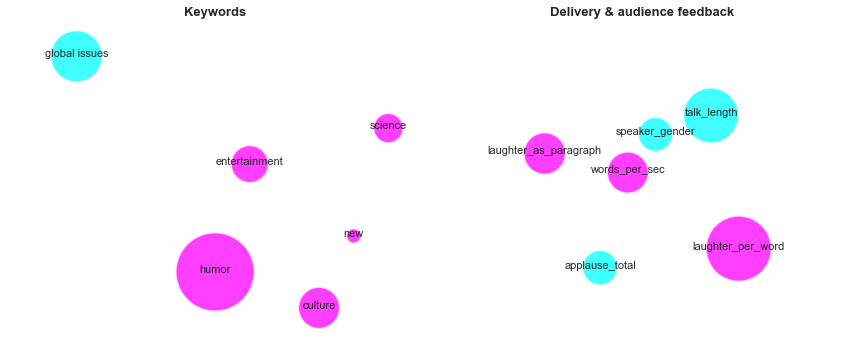

In [540]:
fig, axes=plt.subplots(figsize = (12,5),nrows=1, ncols=2)
titles = ['Keywords','Delivery & audience feedback']
keys = [keykws4,keydeli4]
for ind in xrange(2):
    ax = axes[ind]
    bubbleplot(keys[ind],4000,ax)
    ax.set_title(titles[ind],fontsize = 13, fontweight = 'bold')
fig.tight_layout()

###5.7 Conditional distribution of features against talk labels 

####Talk length

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

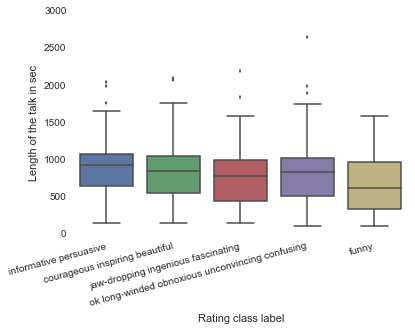

In [138]:
ax0 = sns.boxplot(Xdf_allf.talk_length,groupby=Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('Length of the talk in sec')
ax0.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')

####Talking speed 

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

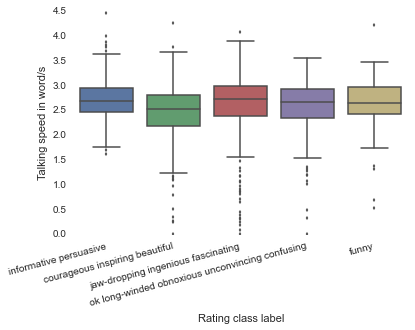

In [140]:
ax1 = sns.boxplot(Xdf_allf.words_per_sec, groupby = Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('Talking speed in word/s')
ax1.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')

####Use of digression or interjections 

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

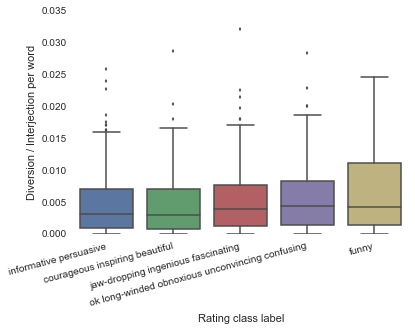

In [142]:
ax4 = sns.boxplot(Xdf_allf.interjections_per_word,groupby = Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('Diversion / Interjection per word')
ax4.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')

####Include personal story? 

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

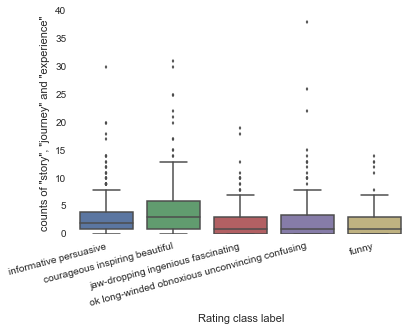

In [143]:
ax3 = sns.boxplot(Xdf_allf.story_words,groupby = Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('counts of "story", "journey" and "experience"')
ax3.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')

####Use of "I (don't|actually) think" 

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

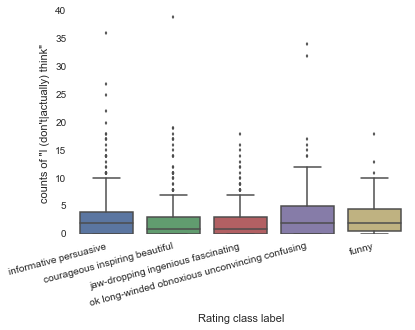

In [146]:
ax3 = sns.boxplot(Xdf_allf.Ithink,groupby = Xdf_allf.label)
plt.xlabel('Rating class label')
plt.ylabel('counts of "I (don\'t|actually) think"')
ax3.set_xticklabels(['informative persuasive','courageous inspiring beautiful','jaw-dropping ingenious fascinating',
          'ok long-winded obnoxious unconvincing confusing','funny'])
plt.xticks(rotation = 15, ha = 'right')